# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune a pretrained Vision model for Image Classification.

This notebook is built to run on the [**CIFAR-10** dataset](https://huggingface.co/datasets/cifar10) with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head (e.g. [ViTForImageClassification](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification), [SwinForImageClassification](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification), [ConvNextForImageClassification](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)). 

Note that you can easily tweak this notebook to run on your own, custom dataset.

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly:

In [1]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
batch_size = 32

Before we start, let's install the `datasets` and `transformers` libraries.

In [2]:
!pip install -q datasets transformers

     |████████████████████████████████| 311 kB 13.5 MB/s 
     |████████████████████████████████| 3.5 MB 51.8 MB/s 
     |████████████████████████████████| 243 kB 69.5 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 133 kB 46.3 MB/s 
     |████████████████████████████████| 596 kB 12.9 MB/s 
     |████████████████████████████████| 895 kB 51.4 MB/s 
     |████████████████████████████████| 6.8 MB 42.1 MB/s 
     |████████████████████████████████| 271 kB 52.9 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 144 kB 70.8 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store



Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
%%capture
!apt install git-lfs

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the Accuracy metric we need to use for evaluation. This can be easily done with the functions `load_dataset` and `load_metric`.  

In [5]:
from datasets import load_dataset, load_metric

In [6]:
dataset = load_dataset("cifar10")
metric = load_metric("accuracy")

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/799 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training and testing.

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [8]:
dataset["test"][10]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FBF62B0BC50>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [9]:
dataset["train"].features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], names_file=None, id=None)}

The cool thing is that we can directly view the image (as the 'img' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

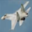

In [10]:
dataset["test"][10]['img']

Let's make it a little bigger as the images in the CIFAR-10 dataset are of low resolution (32x32 pixels):

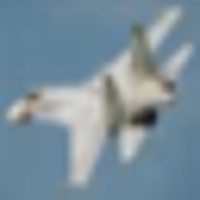

In [11]:
dataset["test"][10]['img'].resize((200, 200))

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [12]:
dataset["train"].features["label"]

ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], names_file=None, id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [13]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["0"]

'airplane'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resize them to a particular size (2) normalize the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. 

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [14]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

The Datasets library requires to write custom functions, which one can then apply on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [15]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(example_batch):
    """Apply _train_transforms across a batch."""
    example_batch["pixel_values"] = [
        _train_transforms(pil_img.convert("RGB")) for pil_img in example_batch["img"]
    ]
    return example_batch

def val_transforms(example_batch):
    """Apply _val_transforms across a batch."""
    example_batch["pixel_values"] = [_val_transforms(pil_img.convert("RGB")) for pil_img in example_batch["img"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM). In other words, we have data augmentation applied on-the-fly.

In [16]:
dataset["train"].set_transform(train_transforms)
dataset["test"].set_transform(val_transforms)

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Like with the feature extractor, the `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels`, `label2id`, and `id2label` alongside the `model_checkpoint` here:

In [17]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `pooler` layer) and randomly initializing some other (the weights and bias of the `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [18]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-cifar10",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [19]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [20]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/nielsr/vit-base-patch16-224-in21k-finetuned-cifar10 into local empty directory.


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 50000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1170


Epoch,Training Loss,Validation Loss,Accuracy
0,0.400700,0.196273,0.980700


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-in21k-finetuned-cifar10/checkpoint-390
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10/checkpoint-390/config.json
Model weights saved in vit-base-patch16-224-in21k-finetuned-cifar10/checkpoint-390/pytorch_model.bin
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10/checkpoint-390/preprocessor_config.json
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10/preprocessor_config.json


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate()

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```